# LRG Position Matching

We need a sample of LRGs that span the range of redshifts and i-band magnitudes found in the OM10 catalog. The sample can be kept small by selecting in color as well as magnitude and redshift. CFHTLS is our first choice, given the depth of the OM10 catalog - but a good LRG pre-selection is not available. In this notebook we explore the CFHTLS option, and then try SDSS instead.

In [1]:
%matplotlib inline
import om10,os
import numpy as np
import matplotlib.pyplot as plt
import triangle

## CFHTLS Experiments

### 1. Downloading CFHTLS Galaxies

First, we need to download a new CFHTLS_LRGs.txt catalog. Let's do this in pieces, to avoid being overloaded with useless blue galaxies. First we put all the downloading code in a `def`, and then run it multiple times with hand-crafted redshift ranges. If you just want to explore the one I made earlier, skip to section 2.

In [6]:
OM10_DIR = os.path.expandvars("$OM10_DIR")

def download_CFHTLS_galaxy_catalog(N,z,imag):
    # Sensible filename:
    output = OM10_DIR+"/data/CFHTLS_galaxies_2015-07-13_{:d}-i-{:d}.txt".format(int(round(imag[0])),int(round(imag[1]))) 
    # Assemble the URL:
    url = "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLens/cgi/queryt.pl?"
    url = url+"REQUEST=doQuery&LANG=ADQL&method=sync&format=ascii&query=SELECT%0D%0Atop+"+str(N)
    url = url+"%0D%0AALPHA_J2000%2C+DELTA_J2000%2C+FLUX_RADIUS%2C+CLASS_STAR%2C+fitclass%2C+Z_B%2C+Z_B_MIN%2C+Z_B_MAX%2C+T_B%2C+star_flag%2C+MAG_u%2C+MAG_g%2C+MAG_r%2C+MAG_i%2C+MAG_y%2C+MAG_z%0D%0A"
    url = url+"FROM%0D%0Acfht.clens%0D%0AWHERE%0D%0Afitclass%3E%3D0%0D%0AAND+fitclass%3C%3D0%0D%0AAND+star_flag%3C%3D0.1%0D%0A"
    url = url+"AND+MAG_i%3E%3D"+str(imag[0])+"%0D%0AAND+MAG_i%3C%3D"+str(imag[1])+"%0D%0A"
    url = url+"AND+Z_B%3E%3D"+str(z[0])+"%0D%0AAND+Z_B%3C%3D"+str(z[1])+"%0D%0A"
    # Download the data with wget:
    !wget -q -O "$output" "$url"
    # Comment out the first line:
    !sed s/'ALPHA'/'# ALPHA'/g "$output" > junk
    !mv junk "$output"
    # Check file for download errors (this happens a lot):
    if 'Error' in open(output).read():
        print "Error downloading data, removing file "+output
        !rm $output
        return None
    else:
        return output

def concatenate_CFHTLS_galaxy_catalogs(filenames):
    input = ' '.join(filenames)
    output = "CFHTLS_galaxies_2015-07-13.txt"
    !cat $input > $output
    !wc -l $output
    return output

In [7]:
N = 10000
filenames = ['a','b','c','d','e','f']
filenames[0] = download_CFHTLS_galaxy_catalog(N,[0.0,0.2],[14.0,16.0])
filenames[1] = download_CFHTLS_galaxy_catalog(N,[.05,0.4],[16.0,18.0])
filenames[2] = download_CFHTLS_galaxy_catalog(N,[0.1,0.7],[18.0,20.0])
filenames[3] = download_CFHTLS_galaxy_catalog(N,[.25,1.7],[20.0,22.0])
filenames[4] = download_CFHTLS_galaxy_catalog(N,[0.5,2.7],[22.0,24.0])
filenames[5] = download_CFHTLS_galaxy_catalog(N,[1.0,3.0],[24.0,26.0])
print filenames

Error downloading data, removing file /Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_20-i-22.txt
['/Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_14-i-16.txt', '/Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_16-i-18.txt', '/Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_18-i-20.txt', None, '/Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_22-i-24.txt', '/Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_24-i-26.txt']


In [8]:
filenames[3] = download_CFHTLS_galaxy_catalog(N,[.25,1.7],[20.0,22.0])

Error downloading data, removing file /Users/pjm/work/stronglensing/OM10/data/CFHTLS_galaxies_2015-07-13_20-i-22.txt


Notice how the data doesn't always download, so I needed this extra cell to try the failed search again... Such failures are purportedly due to an error on the server side. A better function would try the download again until it worked! For now, let's press on. At the brightest magnitudes, the search doesn't return any objects: perhaps these galaxies were too bright for the exposure time, saturated, and got flagged out of the catalog?

In [9]:
galaxyfile = concatenate_CFHTLS_galaxy_catalogs([f for f in filenames if f is not None])

   27202 CFHTLS_galaxies_2015-07-13.txt


### 2. Properties of CFHTLS Galaxies

Now, let's plot this new CFHTLS catalog, and overlay the OM10 lens galaxies.

In [24]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
data = np.loadtxt("CFHTLS_galaxies_2015-07-13.txt")

#### 2.1 Magnitude vs Redshift

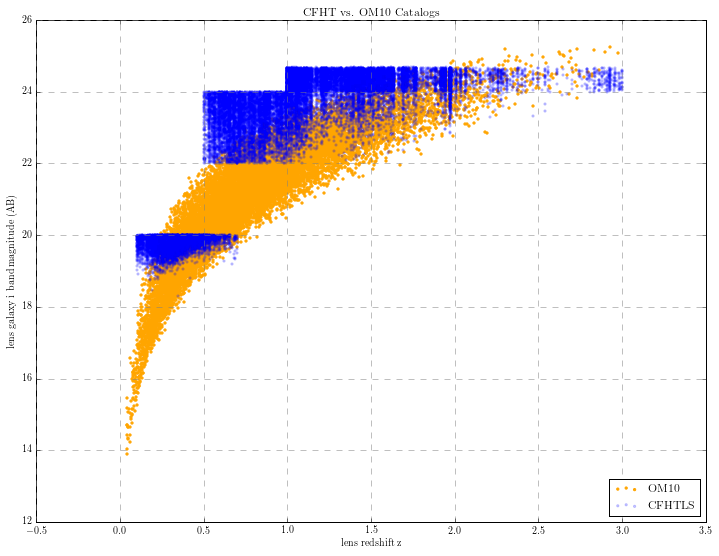

In [11]:
fig = plt.figure()
fig.set_size_inches(12,9)
plt.scatter(db.lenses['ZLENS'],db.lenses['APMAG_I'],color='Orange',marker='.',label='OM10',alpha=1)
plt.scatter(data[:,5],data[:,13],color='Blue',marker='.',label='CFHTLS',alpha=0.2)
plt.title('CFHT vs. OM10 Catalogs')
plt.xlabel('lens redshift z')
plt.ylabel('lens galaxy i band magnitude (AB)')
plt.legend(loc=4)
plt.grid(color='grey', linestyle='--', linewidth=0.5)

This is an attempt at a more restrictive initial selection, to efficiently focus on the brightest galaxies at each redshift bin. The next thing is to try and focus the sample even more, on the red sequence.

#### 2.2 Color - Color - Magnitude - Redshift 

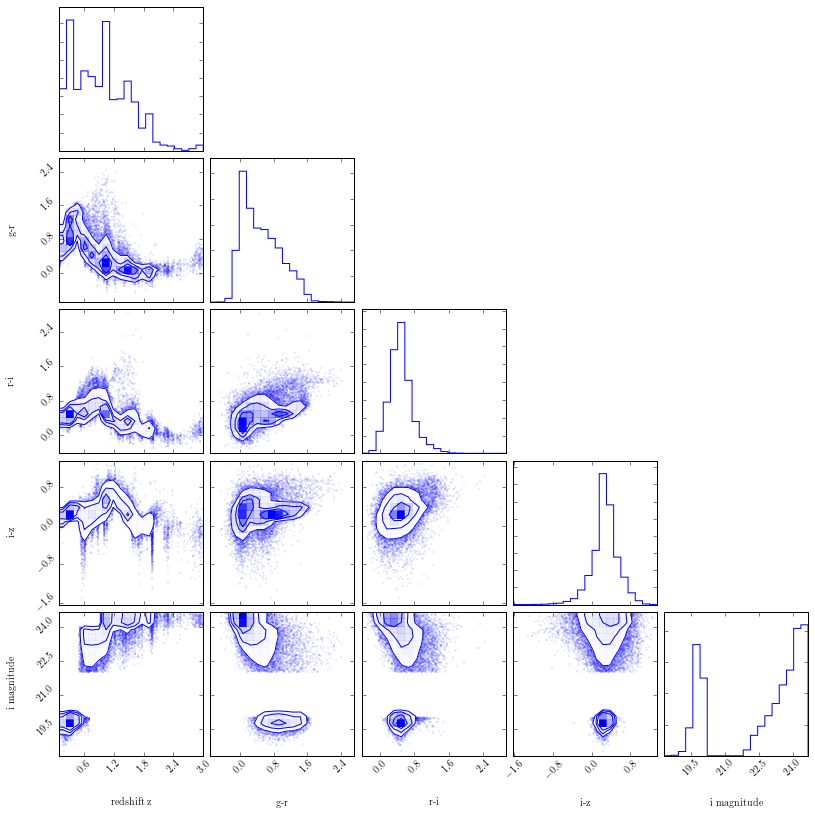

In [17]:
gr = data[:,11] - data[:,12]
ri = data[:,12] - data[:,13]
iz = data[:,13] - data[:,15]
i = data[:,13]
z = data[:,5]

# Clean out extreme colors:
index = np.where((np.abs(ug)<3.0)*(abs(gr)<3.0)*(abs(ri)<3.0)*(abs(iz)<3.0))

plot_of_colors = np.array([z[index], gr[index], ri[index], iz[index], i[index]]).transpose()

# Plot:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')

Look at the g-r vs. redshift panel: as we go to higher redshift, these galaxies are getting *bluer*. We need a better way of selecting old, massive galaxies at redshifts above 1: selecting magnitude-limited samples will just get us a lot of blue, star-forming galaxies. 

When position-matching, we really need to select objects that could plausibly act as lenses, and then paste lensed images on top of them. In the absence of an actual LRG catalog, we are stuck downloading CFHTLS objects and then making color cuts. So, maybe the best thing to do is to *first* paint colors onto the CFHTLS lenses, using the SDSS LRG colors (and some extrapolation to higher z), and *then* find an object with the right colors from the CFHTLS galaxy catalog. Knowing the colors to look for will also help improve the initial download of CFHTLS galaxies - maybe we can restrict ourselves to red galaxies sooner?

### 3. Combining with OM10 Lens Colors from SDSS Painting

Here we use code from the [PS1QLS target selection notebook](https://github.com/mbaumer/OM10/blob/master/notebooks/ps1qls_forecasting.ipynb) to paint the sample of OM10 lens galaxies with SDSS colors. The SDSS filters are very close to the MegaCam filters, so we can just use the painted values in our selection.

In [25]:
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')
# db.sample

Now let's plot the colors of these galaxies, over the ones above. Blue contours will show all the CFHTLS galaxies, while orange will show the OM10 lens galaxies as painted with SDSS colors.

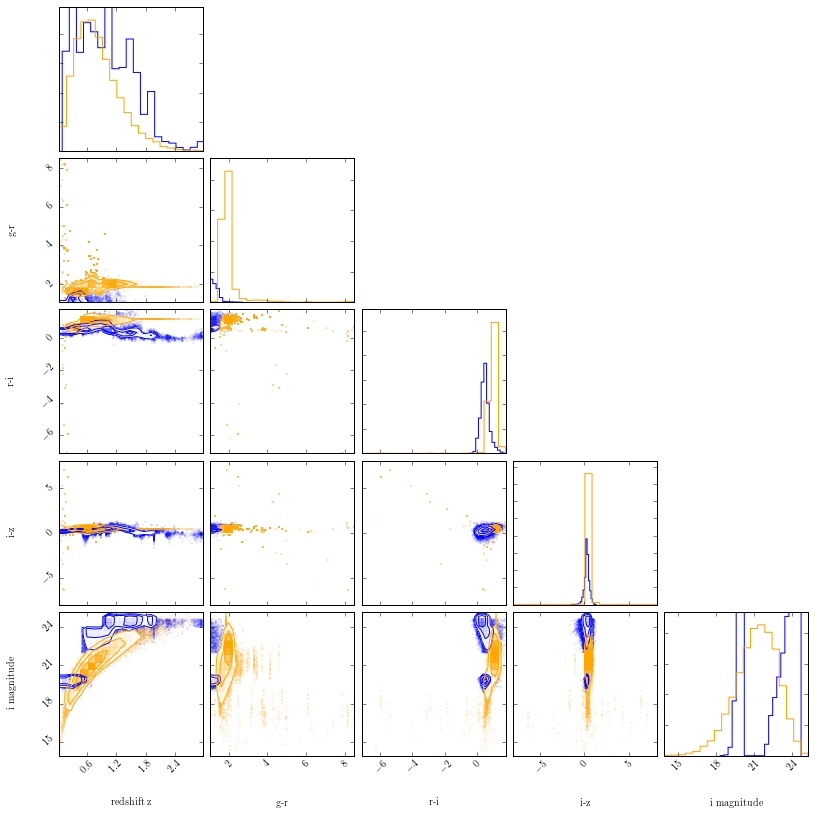

In [22]:
overlay = np.array([db.sample['ZLENS'], \
                    db.sample['MAGG_LENS']-db.sample['MAGR_LENS'], \
                    db.sample['MAGR_LENS']-db.sample['MAGI_LENS'], \
                    db.sample['MAGI_LENS']-db.sample['MAGZ_LENS'], \
                    db.sample['MAGI_LENS']]).transpose()

# Plot with overlay:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')
_ = triangle.corner(overlay,color='orange',fig=fig)


Good: now we can edit the `db.assign_positions()` method to use the painted-on colors. It still looks as though we don't have enough red objects, though: I think the only way round this is to download CFHTLS galaxies in narrower --band magnitude bins, and put a constraint on `(r-i)` at the same time.

### 4. Downloading CFHTLS LRGs directly

Let's try a better download function, that knows about the OM10 lens colors that we are trying to find.

In [2]:
def download_CFHTLS_LRG_catalog(L,N=10000):
    
    i = L['MAGI_LENS']
    z = L['ZLENS']
    c = L['MAGR_LENS'] - L['MAGI_LENS'] 
    
    # Set up redshift bins:
    zmin,zmax = np.min(z),np.max(z)
    Nbins = 20
    Nperbin = int(N/(Nbins*1.0))
    zbins = np.linspace(zmin,zmax,Nbins+1)
    
    # List of filenames to be downloaded:
    filenames = []
    
    # Loop over bins, downloading sub-catalogs:
    for k in np.arange(Nbins):
        
        zmin,zmax = zbins[k],zbins[k+1]
        
        # Sensible filename:
        filename = "CFHTLS_LRGs_2015-07-27_{:.1f}-z-{:.1f}.txt".format(zmin,zmax) 
        output = os.path.expandvars("$OM10_DIR/data/"+filename)
    
        # Get mag and color limits - sigma clip to avoid outliers:
        index = np.where((z > zmin)*(z < zmax))
        
        nsigma = 2.0
        imean,istd = np.mean(i[index]), np.std(i[index])
        imin,imax = imean-nsigma*istd, imean+nsigma*istd
        cmean,cstd = np.mean(c[index]), np.std(c[index])
        cmin,cmax = cmean-nsigma*cstd, cmean+nsigma*cstd
        
        # Translate (r-i) color into r band mag:
        rmin = cmin + imin
        rmax = cmax + imax
        
        print "Querying for LRGs with i, r, z in the ranges",[round(imin,1),round(imax,1)], [round(rmin,1),round(rmax,1)], [round(zmin,1),round(zmax,1)]
        
        # Assemble the URL:
        url = "http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLens/cgi/queryt.pl?"
        url = url+"REQUEST=doQuery&LANG=ADQL&method=sync&format=ascii&query=SELECT%0D%0Atop+"+str(N)
        url = url+"%0D%0AALPHA_J2000%2C+DELTA_J2000%2C+FLUX_RADIUS%2C+CLASS_STAR%2C+fitclass%2C+Z_B%2C+Z_B_MIN%2C+Z_B_MAX%2C+T_B%2C+star_flag%2C+MAG_u%2C+MAG_g%2C+MAG_r%2C+MAG_i%2C+MAG_y%2C+MAG_z%0D%0A"
        url = url+"FROM%0D%0Acfht.clens%0D%0AWHERE%0D%0Afitclass%3E%3D0%0D%0AAND+fitclass%3C%3D0%0D%0AAND+star_flag%3C%3D0.1%0D%0A"
        url = url+"AND+MAG_i%3E%3D"+str(imin)+"%0D%0AAND+MAG_i%3C%3D"+str(imax)+"%0D%0A"
        url = url+"AND+MAG_i%3E%3D"+str(rmin)+"%0D%0AAND+MAG_i%3C%3D"+str(rmax)+"%0D%0A"
        url = url+"AND+Z_B%3E%3D"+str(zmin)+"%0D%0AAND+Z_B%3C%3D"+str(zmax)+"%0D%0A"

        success = None
        while success is None:
            # Download the data with wget:
            !wget -q -O "$output" "$url"
            # Comment out the first line:
            !sed s/'ALPHA'/'# ALPHA'/g "$output" > junk
            !mv junk "$output"
            # Check file for download errors (this happens a lot):
            if 'Error' in open(output).read():
                print "Error downloading data, removing file "+output+" and trying again..."
                !rm $output
                success = None
            else:
                # print "    Successfully downloaded "+str(Nperbin)+" LRGs to file "+output
                !wc -l $output
                break
        
        # Add this file to the list:
        filenames.append(output)
        
    # We should now have all our files downloaded! Concatenate them into one:
    
    input = ' '.join(filenames)
    output = os.path.expandvars("$OM10_DIR/data/CFHTLS_LRGs_2015-07-27.txt")
    !cat $input > $output
    !wc -l $output

    return output

In [3]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')

In [4]:
LRGcatalog = download_CFHTLS_LRG_catalog(db.sample)

Querying for LRGs with i, r, z in the ranges [15.1, 18.9] [12.4, 21.5] [0.0, 0.2]
       4 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27_0.0-z-0.2.txt
Querying for LRGs with i, r, z in the ranges [17.2, 20.1] [15.6, 22.5] [0.2, 0.3]
    3000 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27_0.2-z-0.3.txt
Querying for LRGs with i, r, z in the ranges [18.4, 21.0] [18.9, 21.9] [0.3, 0.5]
   10001 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27_0.3-z-0.5.txt
Querying for LRGs with i, r, z in the ranges [19.2, 21.7] [20.0, 22.9] [0.5, 0.6]
   10001 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27_0.5-z-0.6.txt
Querying for LRGs with i, r, z in the ranges [19.9, 22.3] [20.8, 23.8] [0.6, 0.8]
Error downloading data, removing file /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27_0.6-z-0.8.txt and trying again...
Error downloading data, removing file /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27_0.6-z-0.8.

In [24]:
!echo '# ra dec z mag_u mag_g mag_r mag_i mag_z' > junk
!grep -v '#' ${OM10_DIR}/data/CFHTLS_LRGs_2015-07-27.txt | awk '{print $1,$2,$6,$11,$12,$13,$14,$16}' >> junk
!mv junk ${OM10_DIR}/data/CFHTLS_LRGs_2015-07-27.txt
!wc -l ${OM10_DIR}/data/CFHTLS_LRGs_2015-07-27.txt

    8443 /Users/pjm/work/stronglensing/OM10/data/CFHTLS_LRGs_2015-07-27.txt


OK, now let's read this new catalog in and show it next to the painted OM10 lenses:

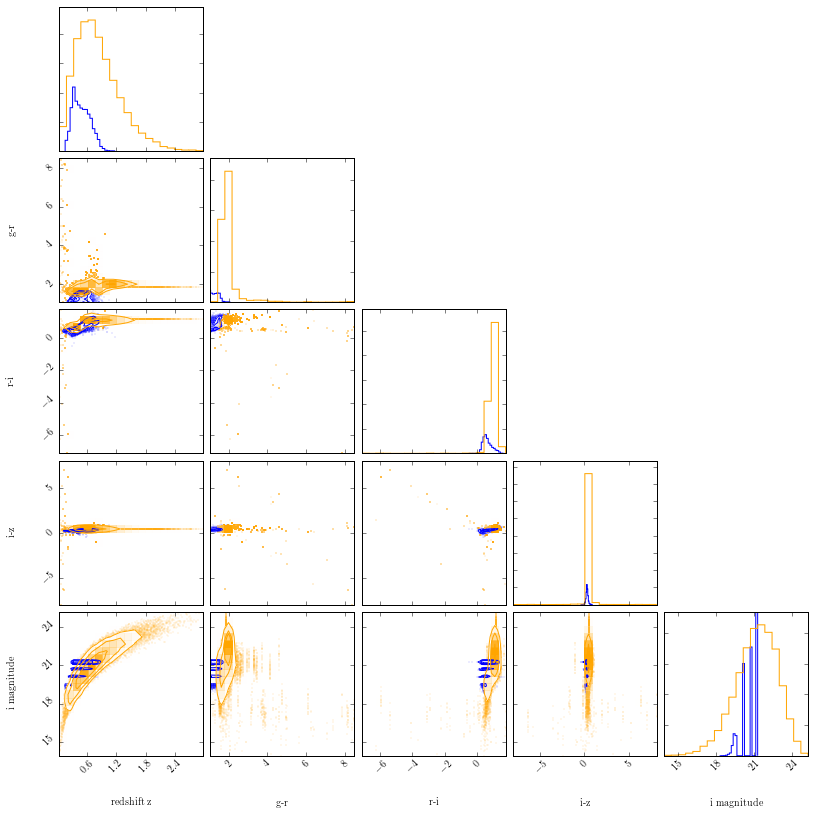

In [25]:
data = np.loadtxt(os.path.expandvars("$OM10_DIR/data/CFHTLS_LRGs_2015-07-27.txt"))
gr = data[:,4] - data[:,5]
ri = data[:,5] - data[:,6]
iz = data[:,6] - data[:,7]
i = data[:,6]
z = data[:,2]

# Clean out extreme colors in sample:
index = np.where((np.abs(gr)<3.0)*(np.abs(ri)<3.0)*(np.abs(iz)<3.0))

plot_of_colors = np.array([z[index], gr[index], ri[index], iz[index], i[index]]).transpose()

# Make overlay from painted OM10 db:
overlay = np.array([db.sample['ZLENS'], \
                    db.sample['MAGG_LENS']-db.sample['MAGR_LENS'], \
                    db.sample['MAGR_LENS']-db.sample['MAGI_LENS'], \
                    db.sample['MAGI_LENS']-db.sample['MAGZ_LENS'], \
                    db.sample['MAGI_LENS']]).transpose()

# Plot with overlay:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')
_ = triangle.corner(overlay,color='orange',fig=fig)

Hmm. Downloads still don't seem to be working correctly...


## SDSS Experiments

The file `data/SDSS_LRGs.txt` is an alternative to `CFHTLS_LRGs.txt` for use in position matching. It's not as deep, but that's OK for lens searches in PS1, for example. Let's see what it looks like compared to the painted OM10 lenses.

In [6]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
data = np.loadtxt(os.path.expandvars("$OM10_DIR/data/SDSS_LRGs.txt"))
db.paint(lrg_input_cat='$OM10_DIR/data/LRGo.txt',qso_input_cat='$OM10_DIR/data/QSOo.txt')

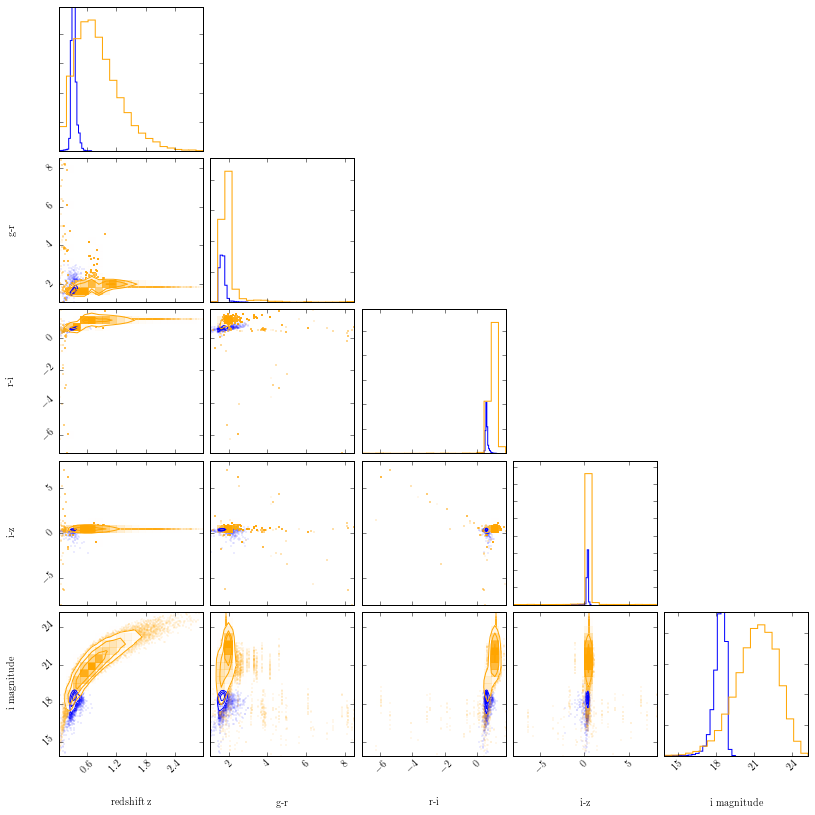

In [11]:
gr = data[:,4] - data[:,5]
ri = data[:,5] - data[:,6]
iz = data[:,6] - data[:,7]
i = data[:,6]
z = data[:,2]

# Clean out extreme colors in SDSS sample:
index = np.where((np.abs(gr)<3.0)*(np.abs(ri)<3.0)*(np.abs(iz)<3.0))

plot_of_colors = np.array([z[index], gr[index], ri[index], iz[index], i[index]]).transpose()

# Make overlay from painted OM10 db:
overlay = np.array([db.sample['ZLENS'], \
                    db.sample['MAGG_LENS']-db.sample['MAGR_LENS'], \
                    db.sample['MAGR_LENS']-db.sample['MAGI_LENS'], \
                    db.sample['MAGI_LENS']-db.sample['MAGZ_LENS'], \
                    db.sample['MAGI_LENS']]).transpose()

# Plot with overlay:
fig = triangle.corner(plot_of_colors,labels=['redshift z','g-r','r-i','i-z','i magnitude'],color='Blue')
_ = triangle.corner(overlay,color='orange',fig=fig)

So, we have a problem: the SDSS LRG selection only returns very bright (i < 19) objects! This was why we went for CFHTLS initially. What we really need is a CFHTLS LRG catalog. 

#Testing color-based positioning code

In [1]:
%matplotlib inline
import om10,os
import numpy as np
import matplotlib.pyplot as plt
import triangle

In [2]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))
db.paint()

In [3]:
db.get_sky_positions()

om10.DB: read in LRG sky position data from  /Users/mbaumer/pybin/OM10/data/CFHTLS_LRGs.txt
Mean LRG RA,DEC,z =  34.3807307408 -7.09643979181 0.612498 21.63331883
Mean LRG i,(g-r) =  34.3807307408 -7.09643979181 0.612498 21.63331883
om10.DB: number of LRGs stored =  10000


In [5]:
idx_list = db.assign_sky_positions()

Working! Let's verify colors:

In [8]:
idx_list = np.array(idx_list).flatten() #list/array hijinks

(array([  2.25300000e+03,   8.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   1.36000000e+02,   2.71000000e+02,
          4.06000000e+02,   5.41000000e+02,   6.76000000e+02,
          8.11000000e+02,   9.46000000e+02,   1.08100000e+03,
          1.21600000e+03,   1.35100000e+03]),
 <a list of 10 Patch objects>)

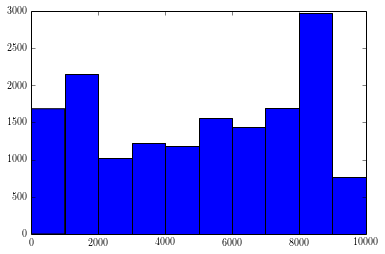

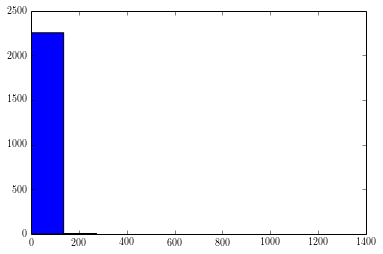

In [15]:
import scipy
from scipy.stats import itemfreq
_ = plt.hist(idx_list)
test = itemfreq(idx_list)
plt.figure()
plt.hist(test[:,1].flatten())

In [28]:
np.where([test == np.max(test[:,0])])

(array([0]), array([2265]), array([0]))

In [27]:
np.sort(test)

array([[  2.00000000e+00,   7.00000000e+00],
       [  2.00000000e+00,   6.00000000e+00],
       [  1.00000000e+00,   1.50000000e+01],
       ..., 
       [  1.00000000e+00,   9.97500000e+03],
       [  1.00000000e+00,   9.99700000e+03],
       [  2.00000000e+00,   9.99900000e+03]])

In [29]:
test[2265,:]

array([  9.99900000e+03,   2.00000000e+00])

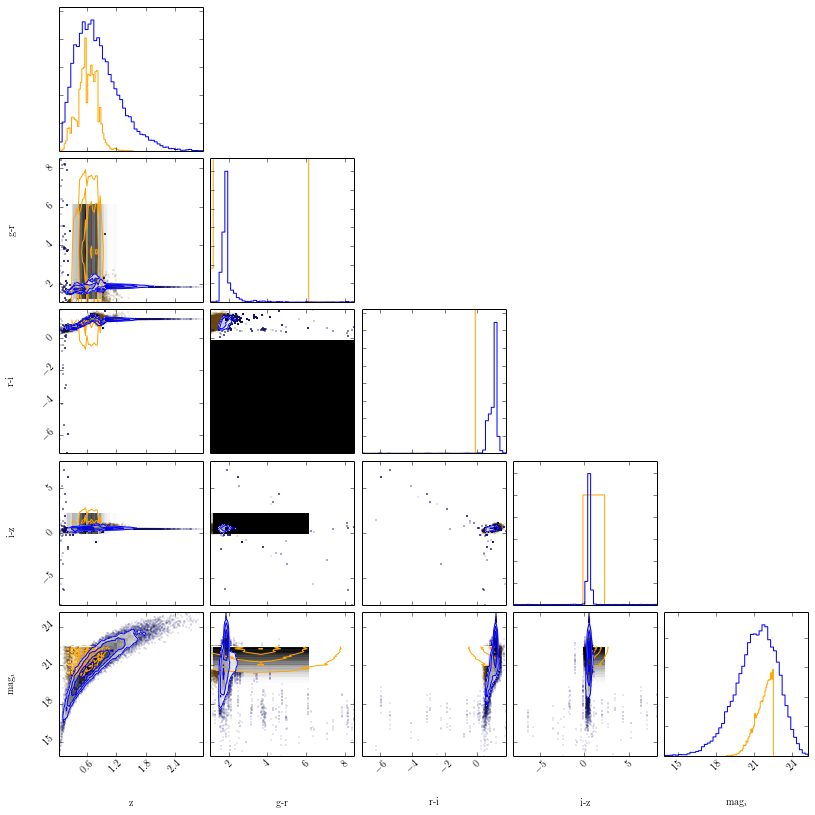

In [35]:
lens = db.sample

ref_features = np.array([db.LRGs['redshift'], db.LRGs['g-r'], db.LRGs['r-i'], \
                         db.LRGs['i-z'], db.LRGs['mag_i']]).transpose()

lens_features = np.array([lens['ZLENS'], lens['MAGG_LENS']-lens['MAGR_LENS'], \
            lens['MAGR_LENS']-lens['MAGI_LENS'], lens['MAGI_LENS']-lens['MAGZ_LENS'], lens['APMAG_I']]).transpose()

fig1 = triangle.corner(ref_features,labels=['z','g-r','r-i','i-z','mag_i'],color='Orange')
_ = triangle.corner(lens_features,fig=fig1,color='Blue')